<i>Updated 22/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />


# Training of Generative Adversarial Network for Camel dataset with Tensorflow 2 on Google Colab

Train Generative Adversarial Network (GAN) on Camel dataset.

## Camel データセットに対して Generative Adversarial Network をGoogle Colab 上の Tensorflow 2 で学習する

Camel データセットに対してGenerative Adversarial Network (GAN) を学習させる。




In [1]:
#! pip install tensorflow==2.7.0

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


# Check the Google Colab runtime environment

## Google Colab 実行環境を調べる

In [3]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Mon Nov 22 15:19:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab

## Google Colab から GoogleDrive をマウントする

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! ls /content/drive

MyDrive  Shareddrives


# Download source file from Google Drive or nw.tsuda.ac.jp

Basically, <code>gdown</code> from Google Drive.
Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

# Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする

基本的に、Google Drive から <code>gdown</code> してください。
Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [6]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True:   # from Google Drive
    url_model =  'https://drive.google.com/uc?id=1_kNWJThcbyltlrIofQ7KcpVGefXB6f2C'
    ! (cd {nw_path}; gdown {url_model})
else:      # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/GAN.py'
    ! wget -nd {url_model} -P {nw_path}

Downloading...
From: https://drive.google.com/uc?id=1_kNWJThcbyltlrIofQ7KcpVGefXB6f2C
To: /content/nw/GAN.py
100% 15.9k/15.9k [00:00<00:00, 13.1MB/s]


In [7]:
! cat {nw_path}/GAN.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle as pkl
import datetime


class GAN():
    def __init__(
        self,
        input_dim,
        discriminator_conv_filters,
        discriminator_conv_kernel_size,
        discriminator_conv_strides,
        discriminator_batch_norm_momentum,
        discriminator_activation,
        discriminator_dropout_rate,
        discriminator_learning_rate,
        generator_initial_dense_layer_size,
        generator_upsample,
        generator_conv_filters,
        generator_conv_kernel_size,
        generator_conv_strides,
        generator_batch_norm_momentum,
        generator_activation,
        generator_dropout_rate,
        generator_learning_rate,
        optimizer,
        z_dim,
        epoch = 0,
        d_losses = [],
        g_losses = []
    ):
        self.name = 'gan'
        self.input_dim = input_dim
        
        self.discriminator_conv_filters = discriminator_conv_filters

# Preparing Camel dataset

Download the camel.npy, which is one of Google's "Quick, Draw!" dataset from https://bit.ly/30HyNqg  .
Downloaded filename will be full_numpy_bitmap_camel.npy.


full_numpy_bitmap_camel.npy mirrored on my Google Drive:    
<a href="https://drive.google.com/file/d/1ZUTfp7tbliCfEdhG8jT0xfCTu3ick4Ud/view?usp=sharing">
https://drive.google.com/file/d/1ZUTfp7tbliCfEdhG8jT0xfCTu3ick4Ud/view?usp=sharing
</a>

## Camel データセットを用意する

Google の Quick, Draw! データセット
https://bit.ly/30HyNqg 
から camel.npy をダウンロードする。
ダウンロードしたファイル名は
full_numpy_bitmap_camel.npy
となる。


自分の Google Drive 上にミラーした full_numpy_bitmap_camel.npy:    
<a href="https://drive.google.com/file/d/1ZUTfp7tbliCfEdhG8jT0xfCTu3ick4Ud/view?usp=sharing">
https://drive.google.com/file/d/1ZUTfp7tbliCfEdhG8jT0xfCTu3ick4Ud/view?usp=sharing
</a>

In [8]:
# Download full_numpy_bitmap_camel.npy from GoogleDrive

MIRRORED_URL = ' https://drive.google.com/uc?id=1ZUTfp7tbliCfEdhG8jT0xfCTu3ick4Ud'

DATA_DIR = 'data'
!mkdir -p {DATA_DIR}

! (cd {DATA_DIR} ; gdown {MIRRORED_URL})

Downloading...
From: https://drive.google.com/uc?id=1ZUTfp7tbliCfEdhG8jT0xfCTu3ick4Ud
To: /content/data/full_numpy_bitmap_camel.npy
100% 95.2M/95.2M [00:00<00:00, 123MB/s] 


In [9]:
! ls -l {DATA_DIR}

total 92948
-rw-r--r-- 1 root root 95176896 Nov 22 15:20 full_numpy_bitmap_camel.npy


# Check the Camel dataset

## Camel データセットを確認する

In [10]:
# paths to all the image files.

import os
import glob
import numpy as np

data_path = os.path.join(DATA_DIR, 'full_numpy_bitmap_camel.npy')
data_raw = np.load(data_path)

print(data_raw.shape)

all_data = (data_raw.astype('float32') - 127.5) / 127.5  # [0, 255] --> [-1.0, 1.0]
all_data = all_data.reshape(all_data.shape[0], 28, 28, 1)

n_all_data = len(all_data)
print(n_all_data)

(121399, 784)
121399


In [11]:
# select some image files.

n_to_show = 10
selected_indices = np.random.choice(range(n_all_data), n_to_show)
selected_data = all_data[selected_indices]

print(selected_data.shape)

(10, 28, 28, 1)


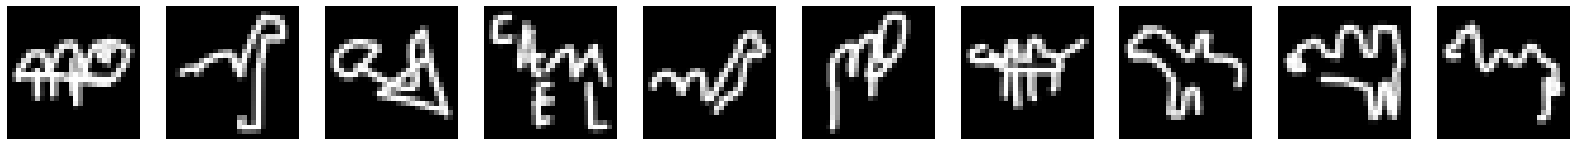

In [12]:
# Display some images.
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, n_to_show, figsize=(2.8 * n_to_show, 2.8))
for i, data in enumerate(selected_data):
    img = (data + 1) / 2
    img = img.reshape(28,28)  # (28,28,1) --> (28, 28)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

plt.show()



# Separate image files for train and test

## 画像ファイルを学習用とテスト用に分割する

In [13]:
split = 0.05

x_train = all_data[: -int(n_all_data * split)]
x_test = all_data[-int(n_all_data * split):]

print(x_train.shape)
print(x_test.shape)

(115330, 28, 28, 1)
(6069, 28, 28, 1)


# Define the Neural Network Model

## ニューラルネットワーク・モデルを定義する

In [14]:
from nw.GAN import GAN

gan = GAN(
    input_dim=(28,28,1),
    discriminator_conv_filters=[64, 64, 128, 128],
    discriminator_conv_kernel_size=[5,5,5,5],
    discriminator_conv_strides=[2,2,2,1],
    discriminator_batch_norm_momentum=None,
    discriminator_activation='relu',
    discriminator_dropout_rate=0.4,
    discriminator_learning_rate=0.0008,
    generator_initial_dense_layer_size=(7,7,64),
    generator_upsample=[2,2,1,1],
    generator_conv_filters=[128,64,64,1],
    generator_conv_kernel_size=[5,5,5,5],
    generator_conv_strides=[1,1,1,1],
    generator_batch_norm_momentum=0.9,
    generator_activation='relu',
    generator_dropout_rate=None,
    generator_learning_rate=0.0004,
    optimizer='rmsprop',
    z_dim=100
)

In [15]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_0 (Conv2  (None, 14, 14, 64)       1664      
 D)                                                              
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv2  (None, 7, 7, 64)         102464    
 D)                                                              
                                                             

In [16]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation_4 (Activation)   (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0   

# Training

## 学習

In [17]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 64

In [18]:
MAX_EPOCHS = 4

# At first, try training a small number of epoch.

## まず、少ない回数だけ学習してみる


In [19]:
save_path1 = '/content/drive/MyDrive/ColabRun/GAN_Camel01'

In [20]:
gan.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs=3,
    run_folder=save_path1
)

1 [D loss: 0.719 R 0.700 F 0.737][D acc: 0.117 R 0.234 F 0.000][G loss: 0.666 acc: 1.000] 0:00:18.361476
2 [D loss: 1.294 R 0.619 F 1.969][D acc: 0.500 R 1.000 F 0.000][G loss: 0.647 acc: 1.000] 0:00:18.447547
3 [D loss: 0.668 R 0.641 F 0.694][D acc: 0.500 R 1.000 F 0.000][G loss: 0.613 acc: 1.000] 0:00:18.519547


In [21]:
print(gan.epoch)

3


In [22]:
# Train the model a little more
# もう少し学習を進めてみる

gan.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 10,
    run_folder = save_path1
)

4 [D loss: 0.658 R 0.618 F 0.697][D acc: 0.500 R 1.000 F 0.000][G loss: 0.557 acc: 1.000] 0:00:00.076358
5 [D loss: 0.633 R 0.564 F 0.701][D acc: 0.500 R 1.000 F 0.000][G loss: 0.406 acc: 1.000] 0:00:00.146730
6 [D loss: 0.596 R 0.426 F 0.766][D acc: 0.500 R 1.000 F 0.000][G loss: 0.185 acc: 1.000] 0:00:00.220313
7 [D loss: 0.677 R 0.211 F 1.143][D acc: 0.500 R 1.000 F 0.000][G loss: 0.301 acc: 1.000] 0:00:00.295547
8 [D loss: 0.668 R 0.310 F 1.025][D acc: 0.500 R 1.000 F 0.000][G loss: 0.399 acc: 1.000] 0:00:00.365424
9 [D loss: 0.723 R 0.376 F 1.070][D acc: 0.500 R 1.000 F 0.000][G loss: 0.547 acc: 1.000] 0:00:00.441662
10 [D loss: 0.686 R 0.458 F 0.913][D acc: 0.500 R 1.000 F 0.000][G loss: 0.610 acc: 1.000] 0:00:00.523697


# Check the loss and accuracy of the training process.

## 学習過程のlossと精度を確認する

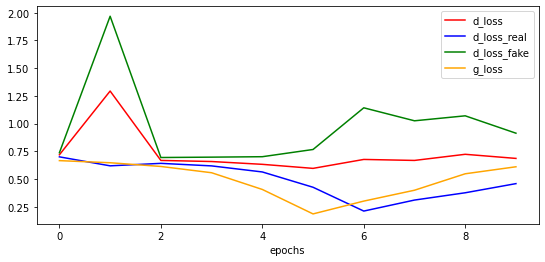

In [23]:
# Display the graph of losses in training
%matplotlib inline

gan.showLoss()

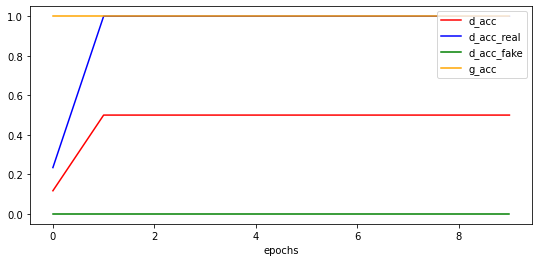

In [24]:
# Display the graph of accuracy in training.
%matplotlib inline

gan.showAcc()

# Check the saved files

## 保存されているファイルを確認する

In [25]:
! ls -lR {save_path1}

/content/drive/MyDrive/ColabRun/GAN_Camel01:
total 1174
-rw------- 1 root root  87471 Nov 22 13:16 params_1000.pkl
-rw------- 1 root root   8396 Nov 22 13:15 params_100.pkl
-rw------- 1 root root   1016 Nov 22 15:20 params_10.pkl
-rw------- 1 root root 175475 Nov 22 13:18 params_2000.pkl
-rw------- 1 root root    442 Nov 22 15:20 params_3.pkl
-rw------- 1 root root 351483 Nov 22 13:20 params_4000.pkl
-rw------- 1 root root  43471 Nov 22 13:16 params_500.pkl
-rw------- 1 root root 527491 Nov 22 13:23 params_6000.pkl
-rw------- 1 root root   1016 Nov 22 15:20 params.pkl
drwx------ 2 root root   4096 Nov 22 15:20 weights

/content/drive/MyDrive/ColabRun/GAN_Camel01/weights:
total 111020
-rw------- 1 root root 2913592 Nov 22 13:16 discriminator-weights_1000.h5
-rw------- 1 root root 2913592 Nov 22 13:15 discriminator-weights_100.h5
-rw------- 1 root root 2913592 Nov 22 15:20 discriminator-weights_10.h5
-rw------- 1 root root 2913592 Nov 22 13:18 discriminator-weights_2000.h5
-rw------- 1 r

# Load the saved file and try further training.

Load the saved parameters and model weights, and try training further.

## セーブしたファイルをロードして、さらに学習を進める

保存してあるパラメータとモデルの重みをロードして、追加の学習を試みる。

In [29]:
# Load the saved parameters and weights.
# 保存してある学習結果をロードする。

gan_work = GAN.load(save_path1)

# Display the epoch count of the model.
# training のepoch回数を表示する。

print(gan_work.epoch)

10


In [30]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 100,
    run_folder = save_path1
)

11 [D loss: 2.874 R 0.474 F 5.274][D acc: 0.500 R 1.000 F 0.000][G loss: 0.609 acc: 1.000] 0:00:02.074458
12 [D loss: 0.612 R 0.450 F 0.773][D acc: 0.500 R 1.000 F 0.000][G loss: 0.611 acc: 1.000] 0:00:02.150539
13 [D loss: 0.607 R 0.415 F 0.799][D acc: 0.500 R 1.000 F 0.000][G loss: 0.616 acc: 1.000] 0:00:02.224499
14 [D loss: 0.579 R 0.363 F 0.795][D acc: 0.500 R 1.000 F 0.000][G loss: 0.629 acc: 1.000] 0:00:02.300022
15 [D loss: 0.546 R 0.306 F 0.785][D acc: 0.500 R 1.000 F 0.000][G loss: 0.643 acc: 1.000] 0:00:02.378579
16 [D loss: 0.500 R 0.226 F 0.774][D acc: 0.500 R 1.000 F 0.000][G loss: 0.655 acc: 1.000] 0:00:02.452946
17 [D loss: 0.454 R 0.154 F 0.755][D acc: 0.500 R 1.000 F 0.000][G loss: 0.674 acc: 1.000] 0:00:02.548717
18 [D loss: 0.398 R 0.072 F 0.725][D acc: 0.500 R 1.000 F 0.000][G loss: 0.691 acc: 0.766] 0:00:02.624110
19 [D loss: 0.362 R 0.026 F 0.698][D acc: 0.523 R 1.000 F 0.047][G loss: 0.705 acc: 0.000] 0:00:02.695926
20 [D loss: 0.345 R 0.009 F 0.680][D acc: 1.00

In [31]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 500,
    run_folder = save_path1,
    print_every_n_batches = 2000
)

101 [D loss: 0.650 R 0.543 F 0.756][D acc: 0.664 R 0.828 F 0.500][G loss: 0.880 acc: 0.109] 0:00:00.094852
102 [D loss: 0.624 R 0.522 F 0.727][D acc: 0.664 R 0.844 F 0.484][G loss: 0.899 acc: 0.141] 0:00:00.171586
103 [D loss: 0.592 R 0.451 F 0.732][D acc: 0.688 R 0.906 F 0.469][G loss: 0.900 acc: 0.172] 0:00:00.253105
104 [D loss: 0.665 R 0.565 F 0.765][D acc: 0.602 R 0.797 F 0.406][G loss: 0.902 acc: 0.031] 0:00:00.328818
105 [D loss: 0.577 R 0.450 F 0.703][D acc: 0.680 R 0.828 F 0.531][G loss: 1.014 acc: 0.047] 0:00:00.402697
106 [D loss: 0.670 R 0.560 F 0.781][D acc: 0.594 R 0.797 F 0.391][G loss: 0.989 acc: 0.000] 0:00:00.475427
107 [D loss: 0.674 R 0.570 F 0.778][D acc: 0.562 R 0.734 F 0.391][G loss: 0.968 acc: 0.031] 0:00:00.556540
108 [D loss: 0.683 R 0.569 F 0.797][D acc: 0.547 R 0.719 F 0.375][G loss: 0.989 acc: 0.016] 0:00:00.628548
109 [D loss: 0.678 R 0.649 F 0.706][D acc: 0.594 R 0.703 F 0.484][G loss: 0.959 acc: 0.047] 0:00:00.706406
110 [D loss: 0.629 R 0.588 F 0.670][D

In [32]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 1000,
    run_folder = save_path1
)

501 [D loss: 0.609 R 0.583 F 0.635][D acc: 0.617 R 0.578 F 0.656][G loss: 1.001 acc: 0.094] 0:00:00.087440
502 [D loss: 0.650 R 0.594 F 0.706][D acc: 0.555 R 0.578 F 0.531][G loss: 1.028 acc: 0.156] 0:00:00.184152
503 [D loss: 0.651 R 0.662 F 0.639][D acc: 0.586 R 0.562 F 0.609][G loss: 1.118 acc: 0.125] 0:00:00.261497
504 [D loss: 0.581 R 0.590 F 0.572][D acc: 0.672 R 0.609 F 0.734][G loss: 1.136 acc: 0.109] 0:00:00.341659
505 [D loss: 0.607 R 0.624 F 0.591][D acc: 0.703 R 0.625 F 0.781][G loss: 1.142 acc: 0.141] 0:00:00.413440
506 [D loss: 0.556 R 0.553 F 0.560][D acc: 0.711 R 0.719 F 0.703][G loss: 1.085 acc: 0.203] 0:00:00.498924
507 [D loss: 0.691 R 0.616 F 0.765][D acc: 0.586 R 0.609 F 0.562][G loss: 1.222 acc: 0.078] 0:00:00.580662
508 [D loss: 0.625 R 0.608 F 0.642][D acc: 0.641 R 0.594 F 0.688][G loss: 1.071 acc: 0.172] 0:00:00.662916
509 [D loss: 0.644 R 0.658 F 0.631][D acc: 0.625 R 0.562 F 0.688][G loss: 1.073 acc: 0.203] 0:00:00.741920
510 [D loss: 0.665 R 0.684 F 0.645][D

In [33]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 6000,
    run_folder = save_path1,
    print_every_n_batches = 2000
)

1001 [D loss: 0.571 R 0.491 F 0.650][D acc: 0.664 R 0.688 F 0.641][G loss: 1.211 acc: 0.172] 0:00:00.080392
1002 [D loss: 0.559 R 0.579 F 0.539][D acc: 0.703 R 0.641 F 0.766][G loss: 1.292 acc: 0.125] 0:00:00.156964
1003 [D loss: 0.541 R 0.532 F 0.551][D acc: 0.750 R 0.688 F 0.812][G loss: 1.290 acc: 0.094] 0:00:00.234994
1004 [D loss: 0.537 R 0.446 F 0.628][D acc: 0.773 R 0.797 F 0.750][G loss: 1.198 acc: 0.047] 0:00:00.322648
1005 [D loss: 0.531 R 0.515 F 0.548][D acc: 0.734 R 0.734 F 0.734][G loss: 1.226 acc: 0.078] 0:00:00.414984
1006 [D loss: 0.567 R 0.574 F 0.560][D acc: 0.672 R 0.641 F 0.703][G loss: 1.338 acc: 0.109] 0:00:00.497695
1007 [D loss: 0.554 R 0.630 F 0.479][D acc: 0.695 R 0.562 F 0.828][G loss: 1.400 acc: 0.062] 0:00:00.574185
1008 [D loss: 0.614 R 0.623 F 0.605][D acc: 0.633 R 0.547 F 0.719][G loss: 1.261 acc: 0.094] 0:00:00.647186
1009 [D loss: 0.564 R 0.590 F 0.539][D acc: 0.719 R 0.625 F 0.812][G loss: 1.276 acc: 0.141] 0:00:00.737941
1010 [D loss: 0.603 R 0.555 

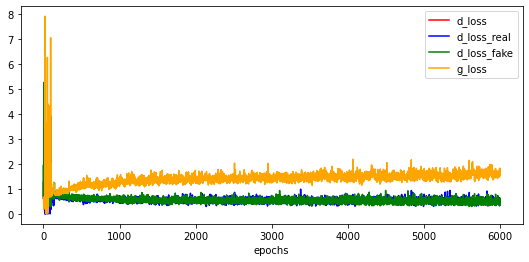

In [34]:
# Display the graph of losses in training
%matplotlib inline

gan_work.showLoss()

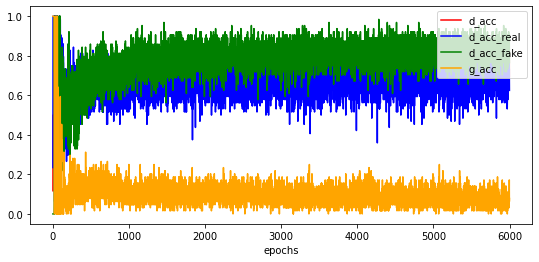

In [35]:
# Display the graph of accuracy in training
%matplotlib inline

gan_work.showAcc()

# Generate Images from 100-dimensional noise vector

# 100次元のノイズ・ベクトルから画像を生成してみる

In [36]:
# prepare the noise vector

rows, cols = 5, 5

noise = np.random.normal(0, 1, (rows * cols, gan.z_dim))

In [37]:
! ls {save_path1}/

params_1000.pkl  params_10.pkl	  params_3.pkl	   params_500.pkl   params.pkl
params_100.pkl	 params_2000.pkl  params_4000.pkl  params_6000.pkl  weights


epoch 3


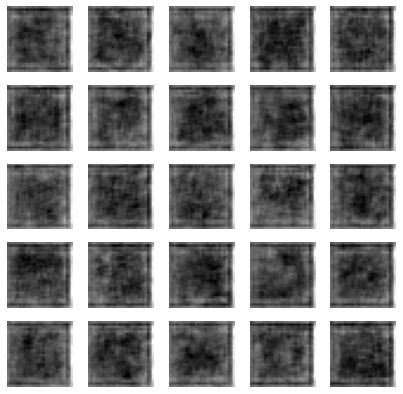

epoch 10


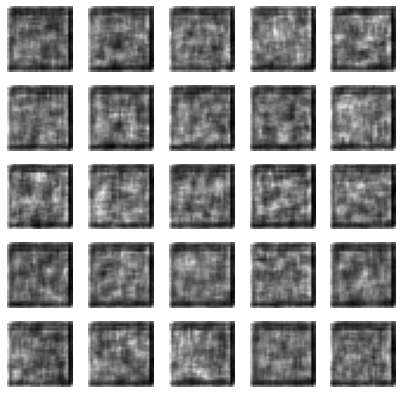

epoch 100


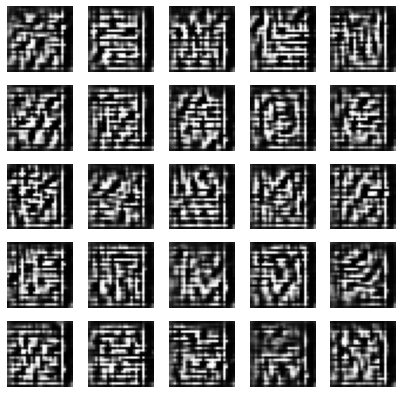

epoch 500


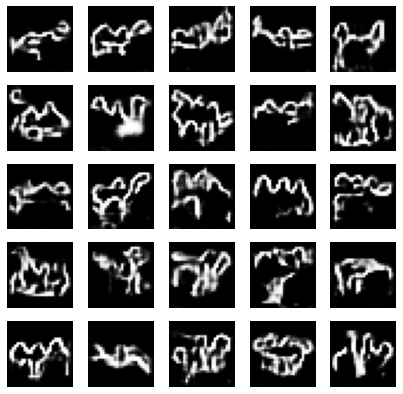

epoch 1000


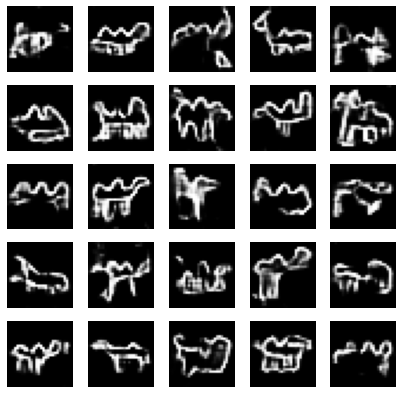

epoch 2000


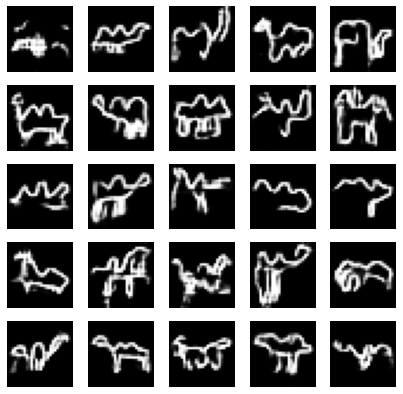

epoch 4000


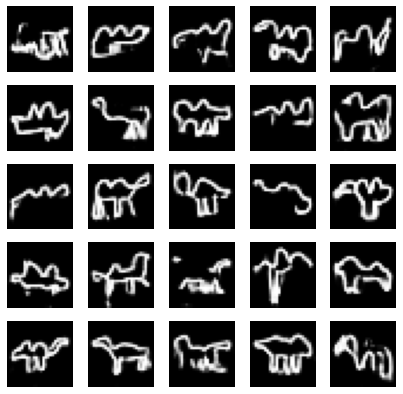

epoch 6000


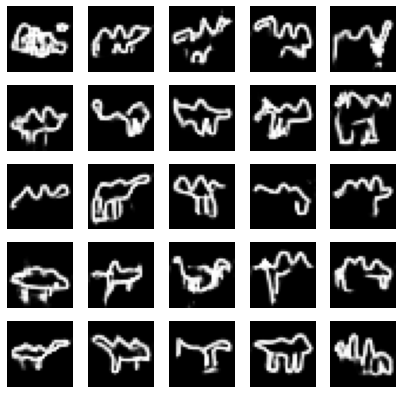

In [38]:
for i in [3, 10, 100, 500, 1000, 2000, 4000, 6000]:
    filepath = os.path.join(save_path1, f'images/images_{i}.png')
    gan = GAN.load(save_path1, i)
    imgs = gan.generate_images(noise).squeeze()
    print(f'epoch {i}')
    GAN.showImages(imgs, rows, cols, 1.4, 1.4)